In [2]:
from functions import *
from import_data import *

from astropy.constants import R_sun, L_sun, sigma_sb
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

In [3]:
# Import data
df_hmxb = HMXB_parameters()
df_sg_params = supergiant_stellar_parameters()
df_falenga = falenga()
df_stellar_params = stellar_params()
df_photometric_params = photometric_params()
df_BJ = BailerJones()

Calculate observed luminosity

In [4]:
df_L = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "L_true": [None] * len(df_hmxb['id']),
                              "L_expected": [None] * len(df_hmxb['id']),
                              "ST_short": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id']),
                              "logL_true/L_sun": [None] * len(df_hmxb['id']),
                              "Teff": [None] * len(df_hmxb['id']),
                              "logTeff": [None] * len(df_hmxb['id'])})

In [5]:
for i in range(df_hmxb.shape[0]):
    # Object id
    id = df_hmxb.loc[i, 'id']

    # Spectral type of object
    spectral_type = df_hmxb.loc[i, "ST"]

    # Effective temperature based on spectral type
    Teff = interpolate(df2=df_stellar_params, spectral_type=spectral_type, quantity='Teff')

    # Expected (B-V)0 of object based on spectral type
    BV0 = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='(B-V)0')

    # Observed (B-V) of object based on simbad filters
    BVobs = df_hmxb.loc[i, '(B-V)obs']

    # Bolometric correction (BC)
    BCv = interpolate(df2=df_photometric_params, spectral_type=spectral_type, quantity='BCv')

    # Distance
    distance = df_BJ.loc[df_BJ['id'] == id, 'r_med_geo'].reset_index(drop=True).at[0]

    # Calculate extinction
    Av = 3.2 * (BVobs - BV0)

    # Calculate Absulute magnitude (visual)
    Mv = df_hmxb.loc[i, 'mv'] - 5 * np.log10(distance) + 5 - Av

    # Calculate bolomatric absolute magnitude
    Mbol = Mv + BCv

    # Calculate the luminosity in solar luminosities
    L = 10**((Mbol - 4.74) / (-2.5))

    # Put L in luminosity dataframe
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "L_true"] = L
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logL_true/L_sun"] = np.log10(L)
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "Teff"] = Teff
    df_L.loc[df_L["id"] == df_hmxb.loc[i, 'id'], "logTeff"] = np.log10(Teff)

Calculate observed radius

In [6]:
# Make radius dataframe
df_R = pd.DataFrame({'id': df_hmxb['id'].copy(),
                              "R_true": [None] * len(df_hmxb['id']),
                              "R_expected": [None] * len(df_hmxb['id']),
                              "ST": [None] * len(df_hmxb['id'])})

for i in range(df_falenga.shape[0]):
    # Orbital separation
    a = df_falenga.loc[i, 'a']
    # Inclination
    inc = df_falenga.loc[i, 'i']
    # Semi eclipse angle
    theta_e = df_falenga.loc[i, 'semi_eclipse_angle']

    # Calculate Radius
    Rob = a * ((np.cos(np.deg2rad(inc)))**2 + (np.sin(np.deg2rad(inc)))**2 * (np.sin(np.deg2rad(theta_e)))**2)**(1/2)

    # Object id
    id = df_falenga.loc[i, 'id']
    # Spectral type
    spectral_type = df_hmxb[df_hmxb["id"] == str(id)]["ST_short"].reset_index(drop=True).at[0]

    # Put R in luminosity dataframe
    df_R.loc[df_R["id"] == id, "R_true"] = Rob
    df_R.loc[df_R["id"] == id, "ST"] = df_hmxb.loc[df_hmxb["id"] == id, "ST"]


Calculate the expected radius from the Teff and the observed luminosity

In [7]:
for i in range(df_hmxb.shape[0]):
    # Spectral type
    spectral_type = df_hmxb.loc[i, 'ST']
    ST_short = df_hmxb.loc[i, 'ST_short']

    # id
    id = df_hmxb.loc[i, 'id']

    # True luminosity
    L = df_L.loc[df_L["id"] == id, "L_true"].reset_index(drop=True).at[0]


    # Effective temperature from model
    Teff = interpolate(df2=df_stellar_params, spectral_type=spectral_type, quantity='Teff')

    # Calculate the radius
    R = np.sqrt((L_sun.value / R_sun.value**2) * (L / (4 * np.pi * sigma_sb.value * Teff**4)))

    # Save luminosity in dataframe
    df_R.loc[i, "R_expected"] = R
    df_R.loc[i, "ST"] = df_hmxb.loc[i, "ST"]

In [8]:
# Calculate ratio
df_R["R_expected/R_true"] = df_R["R_expected"] / df_R["R_true"]

In [9]:
df_R = df_R.dropna()

Mass

In [10]:
df_M = pd.read_excel("tables/M_expBONNSAI.xlsx")
df_M = pd.merge(df_M, df_falenga, on='id')[["id", "M_exp", "M_opt"]]
df_M["M_opt/M_exp"] = df_M["M_opt"] / df_M["M_exp"]

In [11]:
df_MR = pd.merge(df_M, df_R, on='id')

In [17]:
df_MR

,id,M_exp,M_opt,M_opt/M_exp,R_true,R_expected,ST,R_expected/R_true
0,SMC X-1,28.8,18,0.625000,16.254598,20.838732,O9.7Ia+,1.282021
1,Vela X-1,38.4,26,0.677083,33.847001,30.986458,B0.5Ia,0.915486
2,LMC X-4,21.8,18,0.825688,7.975631,11.342181,O8III,1.422105
3,4U1700-37,35.8,46,1.284916,23.198571,17.319267,O6Iafcp,0.746566
4,4U1538-52,22.4,16,0.714286,11.249967,17.721348,B0.2Ia,1.575236
5,Cen X-3,126.4,24,0.189873,12.094002,93.069293,O9III,7.695492


Plot

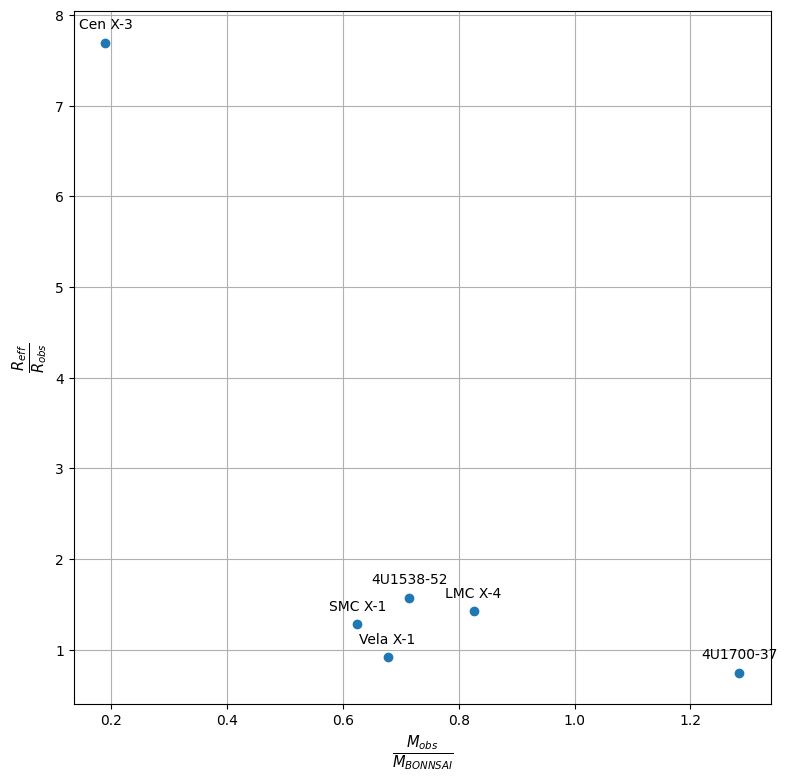

In [20]:
plt.figure(figsize=(9,9))
plt.scatter(df_MR["M_opt/M_exp"], df_MR["R_expected/R_true"])
# Add labels to each point
for i, label in enumerate(df_MR["id"].tolist()):
    plt.annotate(label, (df_MR["M_opt/M_exp"].tolist()[i], df_MR["R_expected/R_true"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')
# plt.ylim(1,2)
# plt.xlim(0,1)
plt.grid(True)
plt.xlabel(r"$\frac{M_{obs}}{M_{BONNSAI}}$", fontsize=15)
plt.ylabel(r"$\frac{R_{eff}}{R_{obs}}$", fontsize=15)
plt.show()

In [14]:
df_L

,id,L_true,L_expected,ST_short,ST,logL_true/L_sun,Teff,logTeff
0,2S0114+650,153646.995447,None,None,None,5.186524,27748.0,4.443232
1,SMC X-1,321188.471,None,None,None,5.50676,30101.0,4.478581
2,LMC X-4,140455.907034,None,None,None,5.14754,33179.0,4.520863
3,Vela X-1,583066.293478,None,None,None,5.765718,28653.0,4.45717
4,Cen X-3,7555336.675468,None,None,None,6.878254,31368.0,4.496487
5,GX301-2,4761113.581809,None,None,None,6.677709,26843.0,4.428831
6,4U1538-52,205579.884484,None,None,None,5.312981,29196.0,4.465323
7,4U1700-37,495668.335316,None,None,None,5.695191,36801.0,4.56586
8,4U1907+09,815429.784813,None,None,None,5.911387,32274.0,4.508853
9,LMC X-1,288097.8443,None,None,None,5.45954,33179.0,4.520863


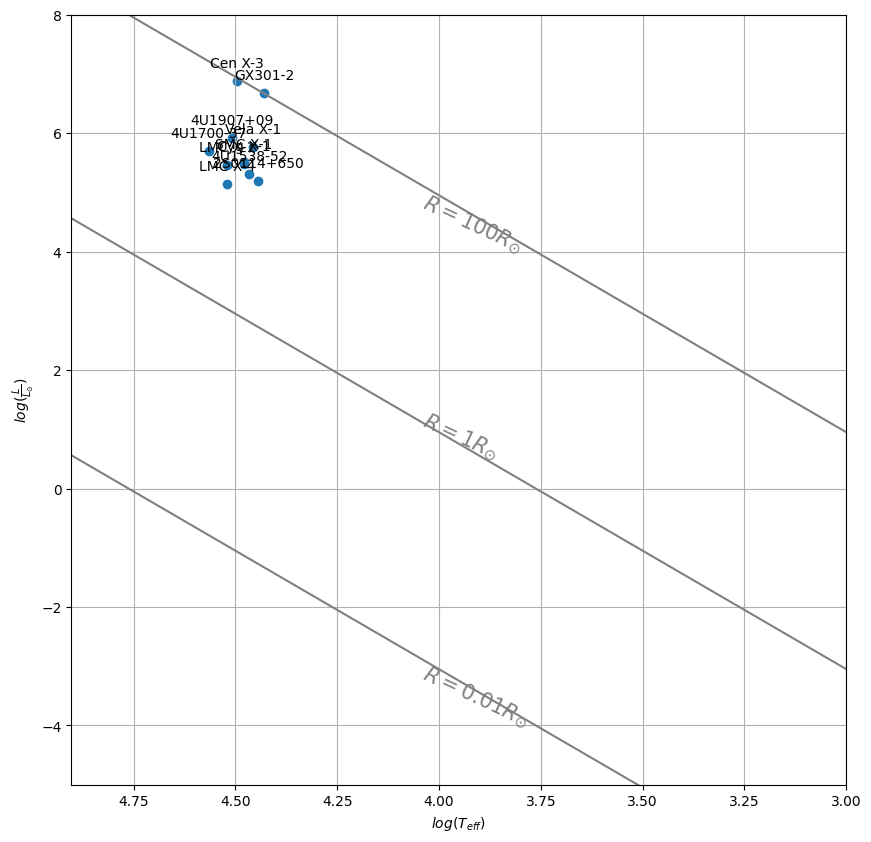

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(df_L["logTeff"], df_L["logL_true/L_sun"])
plt.ylim(-5, 8)
plt.xlim(np.log10(80000),np.log10(1000))
plt.xlabel(r"$log(T_{eff})$")
plt.ylabel(r"$log(\frac{L}{L_{\odot}})$")

def L(Teff, R):
    # Some constants
    sigma = 5.67e-8 # W m-2 k-4
    Rsun = 696340000 # m
    Lsun = 3.86e26 # W

    return np.log10((4 * np.pi * sigma * Rsun**2) / Lsun) + 2 * np.log10(R) + 4 * np.log10(Teff)

radii = [0.01, 1, 100] # Solar radii
T_cR = [10**3, 10**5]
log_T_cR = [3, 5]
L_cR = []

for R in radii:
    save = []
    for T in T_cR:
        save.append(L(T, R))
    L_cR.append(save)

for L in L_cR:
    plt.plot(log_T_cR, L, color='grey')

for i, label in enumerate(df_L["id"].tolist()):
    plt.annotate(label, (df_L["logTeff"].tolist()[i], df_L["logL_true/L_sun"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Add text with radii to lines
plt.text(4.05, 4, s=r'$R = 100R_{\odot}$', rotation=-25, fontsize=15, color='grey')
plt.text(4.05, 0.5, s=r'$R = 1R_{\odot}$', rotation=-25, fontsize=15, color='grey')
plt.text(4.05, -4, s=r'$R = 0.01R_{\odot}$', rotation=-25, fontsize=15, color='grey')

plt.grid(True)
plt.show()

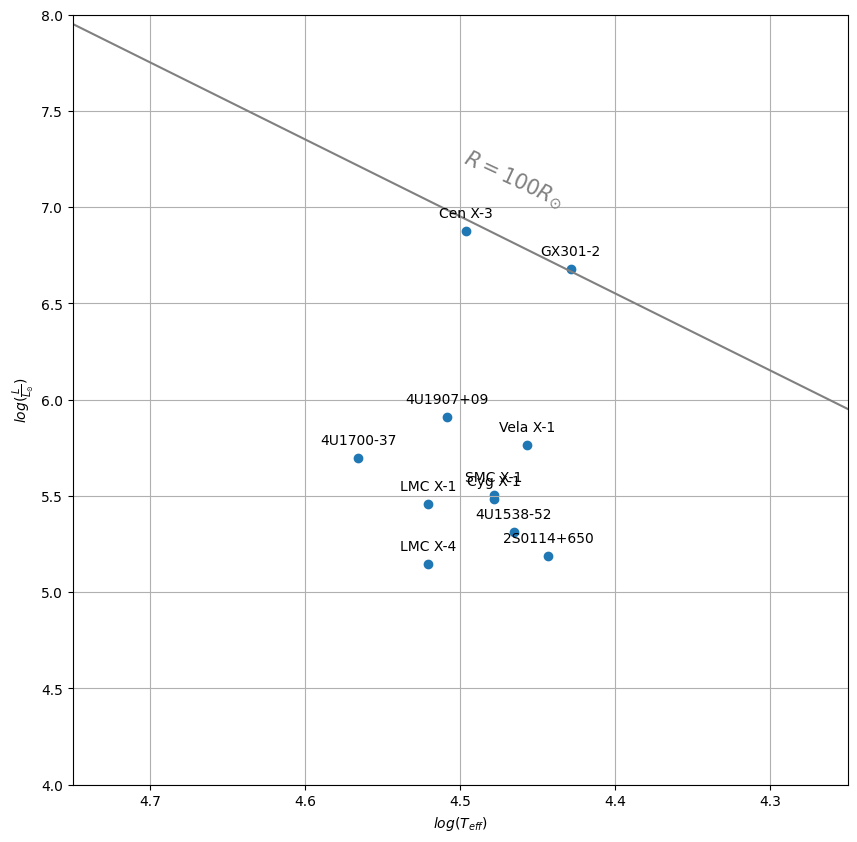

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(df_L["logTeff"], df_L["logL_true/L_sun"])
plt.ylim(4, 8)
plt.xlim(4.75,4.25)
plt.xlabel(r"$log(T_{eff})$")
plt.ylabel(r"$log(\frac{L}{L_{\odot}})$")

def L(Teff, R):
    # Some constants
    sigma = 5.67e-8 # W m-2 k-4
    Rsun = 696340000 # m
    Lsun = 3.86e26 # W

    return np.log10((4 * np.pi * sigma * Rsun**2) / Lsun) + 2 * np.log10(R) + 4 * np.log10(Teff)

radii = [0.01, 1, 100] # Solar radii
T_cR = [10**3, 10**5]
log_T_cR = [3, 5]
L_cR = []

for R in radii:
    save = []
    for T in T_cR:
        save.append(L(T, R))
    L_cR.append(save)

for L in L_cR:
    plt.plot(log_T_cR, L, color='grey')

for i, label in enumerate(df_L["id"].tolist()):
    plt.annotate(label, (df_L["logTeff"].tolist()[i], df_L["logL_true/L_sun"].tolist()[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Add text with radii to lines
plt.text(4.5, 7, s=r'$R = 100R_{\odot}$', rotation=-25, fontsize=15, color='grey')
# plt.text(4.05, 0.5, s=r'$R = 1R_{\odot}$', rotation=-25, fontsize=15, color='grey')
# plt.text(4.05, -4, s=r'$R = 0.01R_{\odot}$', rotation=-25, fontsize=15, color='grey')

plt.grid(True)
plt.show()

In [30]:
df_hmxb

,id,ST,ST_short,ruwe,period,spinperiod,eclipseduration,RV,Mob,Rob,...,distance,distanceBJ,luminosity,(B-V)obs,B,V,(B-V)0,BC,mv,Teff
0,2S0114+650,B1Iae,B1I,0.944642,15.660000,10008.000000,NaN,-80.0,16.00,NaN,...,5091.204930,NaN,NaN,0.85,11.99,11.14,-0.28,-0.98,11.14,25119
1,SMC X-1,O9.7Ia+,O9I,1.002890,NaN,NaN,NaN,NaN,NaN,NaN,...,250514.135002,NaN,NaN,-0.15,13.00,13.15,-0.32,-3.03,13.15,32211
2,LMC X-4,O8III,O8III,1.014480,1.400000,13.500000,NaN,NaN,NaN,NaN,...,225469.097455,NaN,NaN,-0.10,13.90,14.00,-0.32,-3.23,14.00,33963
3,Vela X-1,B0.5Ia,B0I,0.880197,0.000896,283.000000,NaN,-3.2,26.00,NaN,...,2015.153991,NaN,NaN,0.50,7.37,6.87,-0.31,-2.84,6.87,29512
4,Cen X-3,O9III,O9III,1.020704,2.030000,0.000048,NaN,32.0,20.20,NaN,...,7208.804902,NaN,NaN,2.13,14.40,12.27,-0.32,-3.03,12.27,32211
5,GX301-2,B1.5Iaeq,B1I,0.908531,0.041500,680.000000,NaN,4.1,43.00,NaN,...,3990.086209,NaN,NaN,2.04,12.70,10.66,-0.28,-0.98,10.66,25119
6,4U1538-52,B0.2Ia,B0I,0.985791,0.000037,526.420000,NaN,-158.0,20.00,NaN,...,7814.975864,NaN,NaN,1.80,16.30,14.50,-0.31,-2.84,14.50,29512
7,4U1700-37,O6Iafcp,O6I,0.808192,0.000003,NaN,NaN,-60.0,46.00,NaN,...,1580.438316,NaN,NaN,0.27,6.78,6.51,-0.33,-3.58,6.51,38282
8,4U1907+09,O8.5Iab,O8I,0.883853,0.000838,437.500000,NaN,NaN,27.80,NaN,...,4298.703408,NaN,NaN,3.06,19.41,16.35,-0.32,-3.23,16.35,33963
9,LMC X-1,O8III(f)p,O8III,0.996263,3.909170,NaN,NaN,NaN,31.79,NaN,...,36402.117341,NaN,NaN,0.30,14.80,14.50,-0.32,-3.23,14.50,33963
